# Training Model

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from   sklearn.model_selection import train_test_split
from   sklearn.preprocessing import MinMaxScaler, StandardScaler

## Import data

In [2]:
filename_alldata = "data/_nanocomposite_data.csv"
alldata = pd.read_csv(filename_alldata, index_col=None, header=0)
# Drop columns which are not used for now
alldata_clean = alldata.drop(['polymer_p2', 'ratio_1_2','filler_2','wt_l2','owner','foaming'], axis=1)  # , inplace=True
alldata_clean.head()

,polymer_1,filler_1,wt_l1,conductivity
0,HDPEtreated,GNP,13.775164,4.543207
1,HDPEtreated,GNP,5.786208,1.042829
2,HDPEtreated,GNP,11.920008,2.407790
3,HDPEtreated,GNP,15.883304,4.641369
4,HDPEtreated,GNP,12.075694,3.062611


## Prepare Dataset for TensorFlow

### Scaling X and Y data
X data might not need scaling as the range of values is not high.

In [3]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaler.get_params()

{'clip': False, 'copy': True, 'feature_range': (0, 1)}

### The Y label is highly variation
The Y label is the electrical conductivity which is extremely low before the threhold and sudenly increases once the amount of fillers passes the threshold. In this study, the Y values fall mostly in to the range of [1e-3, 1e3], hence, the graph is scaled logarithmically in y-axis.

In [4]:
def safe_log10(data):
    """ A safe function for LOG10 in cases of too small values (close or equal to 0 ) """
    prob_tmp  = np.where(data > 1.0e-10, data, 1.0e-10)
    result    = np.where(data > 1.0e-10, np.log10(prob_tmp), -10)
    return result
    
class superHighVariationScaler:
    """ Standard scaler of Y with multiple scaler 
    Because the range is to high => log10 (values) to play with magnitude order
    To make it organize, use another Scaler following LOG10.
    Default scale is StandardScaler()
    """
    def __init__(self, scaler = None):
        if scaler:
            self.Scaler  = scaler
        else:
            self.Scaler  = StandardScaler()
    def fit_transform(self, data):
        data_loged = safe_log10(data)
        return self.Scaler.fit_transform (data_loged)
    def transform(self, data):
        data_loged = safe_log10(data)
        return self.Scaler.transform (data_loged)
    
    def inverse_transform(self,data):
        data_unloged = self.Scaler.inverse_transform (data)
        return np.float_power(10, data_unloged )

Y_scaler = superHighVariationScaler()  #

You can try other Scaler
```python
Y_scaler = superHighVariationScaler( 
                    MinMaxScaler(feature_range=(0, 1)) )
Y_scaler.Scaler.get_params()
```

### Mapping not Numeric Values / Columns

In [5]:
def mapStringToNum (data):
    polymer_map_list =  {'HDPE':0,'HDPEtreated':1}
    filler_map_list =   {'MWCNT':0,'SWCNT':1,'GNP':2}
    data['polymer_1'] = data['polymer_1'].map(polymer_map_list)
    data['filler_1']  = data['filler_1' ].map(filler_map_list)
    return data

def mapNumToString (data):
    polymer_map_list =  {0:'HDPE',1:'HDPEtreated'}
    filler_map_list =   {0:'MWCNT',1:'SWCNT',2:'GNP'}
    data['polymer_1'] = data['polymer_1'].map(polymer_map_list)
    data['filler_1']  = data['filler_1' ].map(filler_map_list)
    return data

alldata_clean = mapStringToNum(alldata_clean)
alldata_clean.head()

,polymer_1,filler_1,wt_l1,conductivity
0,1,2,13.775164,4.543207
1,1,2,5.786208,1.042829
2,1,2,11.920008,2.407790
3,1,2,15.883304,4.641369
4,1,2,12.075694,3.062611


### Splitting data to training and testing sets

In [6]:
training_data, testing_data = train_test_split(alldata_clean, test_size=0.2, random_state=25) #, random_state=25
print(len(training_data), 'train examples')
print(len(testing_data), 'test examples')
training_data.head()

4000 train examples
1000 test examples


,polymer_1,filler_1,wt_l1,conductivity
1464,1,0,22.724011,242.271594
1394,1,0,8.764358,31.464601
4738,0,1,14.679383,356.669637
2913,0,2,22.698410,0.777631
1757,1,0,10.591977,56.659220


In [7]:
# Split into input features (X) and output labels (Y) variables
X_training = training_data.drop('conductivity', axis=1).values
Y_training = training_data[['conductivity']].values

# Pull out columns for X (data to train with) and Y (value to predict)
X_testing = testing_data.drop('conductivity', axis=1).values
Y_testing = testing_data[['conductivity']].values

### Scaling data

In [8]:
# Scale both the training inputs and outputs
X_scaled_training = X_scaler.fit_transform(X_training)
Y_scaled_training = Y_scaler.fit_transform(Y_training)

# It's very important that the training and test data are scaled with the same scaler.
X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

# Model build and complie

## batch_size: 
Too large of a batch size will lead to poor generalization

Smaller batch sizes could shown to have faster convergence to “good” solutions. 

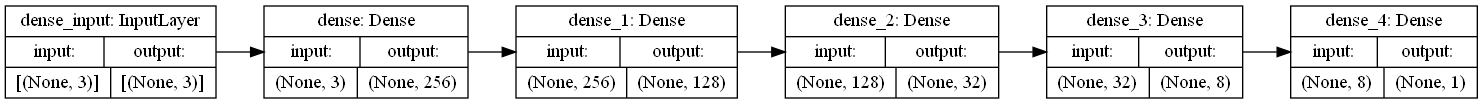

In [9]:
# Create model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(256, activation="relu", input_dim=3))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="linear"))

model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
             metrics = tf.keras.metrics.MeanSquaredLogarithmicError() )
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [10]:
history = model.fit(X_scaled_training, Y_scaled_training, 
                    validation_data=(X_scaled_testing, Y_scaled_testing), 
                    epochs=500, batch_size=64)

Epoch 1/500
63/63 [==============================] - 2s 7ms/step - loss: 99.7429 - mean_squared_logarithmic_error: 0.1815 - val_loss: 101.7307 - val_mean_squared_logarithmic_error: 0.1698
Epoch 2/500
63/63 [==============================] - 0s 3ms/step - loss: 99.7537 - mean_squared_logarithmic_error: 0.1757 - val_loss: 101.6392 - val_mean_squared_logarithmic_error: 0.1652
Epoch 3/500
63/63 [==============================] - 0s 3ms/step - loss: 98.8781 - mean_squared_logarithmic_error: 0.1711 - val_loss: 100.8010 - val_mean_squared_logarithmic_error: 0.1613
Epoch 4/500
63/63 [==============================] - 0s 3ms/step - loss: 97.7994 - mean_squared_logarithmic_error: 0.1668 - val_loss: 101.4602 - val_mean_squared_logarithmic_error: 0.1540
Epoch 5/500
63/63 [==============================] - 0s 3ms/step - loss: 97.9678 - mean_squared_logarithmic_error: 0.1607 - val_loss: 101.2940 - val_mean_squared_logarithmic_error: 0.1484
Epoch 6/500
63/63 [==============================] - 0s 3ms/

63/63 [==============================] - 0s 3ms/step - loss: 50.4902 - mean_squared_logarithmic_error: 0.0341 - val_loss: 58.6464 - val_mean_squared_logarithmic_error: 0.0296
Epoch 45/500
63/63 [==============================] - 0s 4ms/step - loss: 48.7666 - mean_squared_logarithmic_error: 0.0321 - val_loss: 52.8601 - val_mean_squared_logarithmic_error: 0.0241
Epoch 46/500
63/63 [==============================] - 0s 3ms/step - loss: 48.9033 - mean_squared_logarithmic_error: 0.0289 - val_loss: 52.3726 - val_mean_squared_logarithmic_error: 0.0230
Epoch 47/500
63/63 [==============================] - 0s 3ms/step - loss: 47.0314 - mean_squared_logarithmic_error: 0.0254 - val_loss: 54.2983 - val_mean_squared_logarithmic_error: 0.0231
Epoch 48/500
63/63 [==============================] - 0s 3ms/step - loss: 46.0854 - mean_squared_logarithmic_error: 0.0248 - val_loss: 51.2665 - val_mean_squared_logarithmic_error: 0.0186
Epoch 49/500
63/63 [==============================] - 0s 3ms/step - loss:

Epoch 88/500
63/63 [==============================] - 0s 3ms/step - loss: 37.2666 - mean_squared_logarithmic_error: 0.0066 - val_loss: 39.8880 - val_mean_squared_logarithmic_error: 0.0055
Epoch 89/500
63/63 [==============================] - 0s 4ms/step - loss: 36.8611 - mean_squared_logarithmic_error: 0.0061 - val_loss: 42.8749 - val_mean_squared_logarithmic_error: 0.0048
Epoch 90/500
63/63 [==============================] - 0s 3ms/step - loss: 36.5900 - mean_squared_logarithmic_error: 0.0065 - val_loss: 40.8620 - val_mean_squared_logarithmic_error: 0.0051
Epoch 91/500
63/63 [==============================] - 0s 3ms/step - loss: 36.0605 - mean_squared_logarithmic_error: 0.0063 - val_loss: 43.7216 - val_mean_squared_logarithmic_error: 0.0050
Epoch 92/500
63/63 [==============================] - 0s 3ms/step - loss: 36.0157 - mean_squared_logarithmic_error: 0.0062 - val_loss: 42.7675 - val_mean_squared_logarithmic_error: 0.0053
Epoch 93/500
63/63 [==============================] - 0s 3ms

63/63 [==============================] - 0s 4ms/step - loss: 34.5398 - mean_squared_logarithmic_error: 0.0057 - val_loss: 37.1267 - val_mean_squared_logarithmic_error: 0.0047
Epoch 132/500
63/63 [==============================] - 0s 3ms/step - loss: 34.5248 - mean_squared_logarithmic_error: 0.0058 - val_loss: 43.6567 - val_mean_squared_logarithmic_error: 0.0050
Epoch 133/500
63/63 [==============================] - 0s 3ms/step - loss: 34.9835 - mean_squared_logarithmic_error: 0.0057 - val_loss: 38.0026 - val_mean_squared_logarithmic_error: 0.0051
Epoch 134/500
63/63 [==============================] - 0s 4ms/step - loss: 34.0468 - mean_squared_logarithmic_error: 0.0056 - val_loss: 37.9415 - val_mean_squared_logarithmic_error: 0.0051
Epoch 135/500
63/63 [==============================] - 0s 3ms/step - loss: 36.0565 - mean_squared_logarithmic_error: 0.0059 - val_loss: 37.9362 - val_mean_squared_logarithmic_error: 0.0049
Epoch 136/500
63/63 [==============================] - 0s 3ms/step - 

63/63 [==============================] - 0s 3ms/step - loss: 33.4629 - mean_squared_logarithmic_error: 0.0055 - val_loss: 37.5674 - val_mean_squared_logarithmic_error: 0.0048
Epoch 175/500
63/63 [==============================] - 0s 3ms/step - loss: 34.9179 - mean_squared_logarithmic_error: 0.0058 - val_loss: 40.5189 - val_mean_squared_logarithmic_error: 0.0048
Epoch 176/500
63/63 [==============================] - 0s 3ms/step - loss: 34.4205 - mean_squared_logarithmic_error: 0.0060 - val_loss: 38.2469 - val_mean_squared_logarithmic_error: 0.0052
Epoch 177/500
63/63 [==============================] - 0s 3ms/step - loss: 33.6379 - mean_squared_logarithmic_error: 0.0061 - val_loss: 37.9710 - val_mean_squared_logarithmic_error: 0.0048
Epoch 178/500
63/63 [==============================] - 0s 3ms/step - loss: 33.3156 - mean_squared_logarithmic_error: 0.0060 - val_loss: 36.2891 - val_mean_squared_logarithmic_error: 0.0048
Epoch 179/500
63/63 [==============================] - 0s 3ms/step - 

63/63 [==============================] - 0s 3ms/step - loss: 33.1566 - mean_squared_logarithmic_error: 0.0058 - val_loss: 37.3176 - val_mean_squared_logarithmic_error: 0.0050
Epoch 218/500
63/63 [==============================] - 0s 3ms/step - loss: 32.8236 - mean_squared_logarithmic_error: 0.0058 - val_loss: 36.9164 - val_mean_squared_logarithmic_error: 0.0046
Epoch 219/500
63/63 [==============================] - 0s 4ms/step - loss: 32.3669 - mean_squared_logarithmic_error: 0.0057 - val_loss: 33.7878 - val_mean_squared_logarithmic_error: 0.0046
Epoch 220/500
63/63 [==============================] - 0s 4ms/step - loss: 32.6125 - mean_squared_logarithmic_error: 0.0057 - val_loss: 34.8311 - val_mean_squared_logarithmic_error: 0.0046
Epoch 221/500
63/63 [==============================] - 0s 4ms/step - loss: 32.2198 - mean_squared_logarithmic_error: 0.0055 - val_loss: 35.3082 - val_mean_squared_logarithmic_error: 0.0048
Epoch 222/500
63/63 [==============================] - 0s 3ms/step - 

63/63 [==============================] - 0s 3ms/step - loss: 31.1610 - mean_squared_logarithmic_error: 0.0059 - val_loss: 36.0290 - val_mean_squared_logarithmic_error: 0.0057
Epoch 261/500
63/63 [==============================] - 0s 3ms/step - loss: 31.4946 - mean_squared_logarithmic_error: 0.0061 - val_loss: 34.7947 - val_mean_squared_logarithmic_error: 0.0050
Epoch 262/500
63/63 [==============================] - 0s 3ms/step - loss: 31.3336 - mean_squared_logarithmic_error: 0.0060 - val_loss: 34.6037 - val_mean_squared_logarithmic_error: 0.0051
Epoch 263/500
63/63 [==============================] - 0s 3ms/step - loss: 31.3108 - mean_squared_logarithmic_error: 0.0061 - val_loss: 33.3348 - val_mean_squared_logarithmic_error: 0.0049
Epoch 264/500
63/63 [==============================] - 0s 3ms/step - loss: 31.4217 - mean_squared_logarithmic_error: 0.0060 - val_loss: 33.8348 - val_mean_squared_logarithmic_error: 0.0051
Epoch 265/500
63/63 [==============================] - 0s 3ms/step - 

63/63 [==============================] - 0s 3ms/step - loss: 32.2343 - mean_squared_logarithmic_error: 0.0066 - val_loss: 36.5017 - val_mean_squared_logarithmic_error: 0.0052
Epoch 304/500
63/63 [==============================] - 0s 3ms/step - loss: 31.2086 - mean_squared_logarithmic_error: 0.0063 - val_loss: 34.9913 - val_mean_squared_logarithmic_error: 0.0053
Epoch 305/500
63/63 [==============================] - 0s 3ms/step - loss: 31.3869 - mean_squared_logarithmic_error: 0.0064 - val_loss: 35.3133 - val_mean_squared_logarithmic_error: 0.0053
Epoch 306/500
63/63 [==============================] - 0s 3ms/step - loss: 31.9597 - mean_squared_logarithmic_error: 0.0064 - val_loss: 39.4226 - val_mean_squared_logarithmic_error: 0.0050
Epoch 307/500
63/63 [==============================] - 0s 3ms/step - loss: 32.3653 - mean_squared_logarithmic_error: 0.0062 - val_loss: 33.4146 - val_mean_squared_logarithmic_error: 0.0052
Epoch 308/500
63/63 [==============================] - 0s 3ms/step - 

63/63 [==============================] - 0s 3ms/step - loss: 31.4731 - mean_squared_logarithmic_error: 0.0065 - val_loss: 33.1246 - val_mean_squared_logarithmic_error: 0.0051
Epoch 347/500
63/63 [==============================] - 0s 3ms/step - loss: 31.5643 - mean_squared_logarithmic_error: 0.0068 - val_loss: 33.7018 - val_mean_squared_logarithmic_error: 0.0052
Epoch 348/500
63/63 [==============================] - 0s 3ms/step - loss: 30.8645 - mean_squared_logarithmic_error: 0.0065 - val_loss: 34.7308 - val_mean_squared_logarithmic_error: 0.0054
Epoch 349/500
63/63 [==============================] - 0s 3ms/step - loss: 31.8732 - mean_squared_logarithmic_error: 0.0063 - val_loss: 33.7143 - val_mean_squared_logarithmic_error: 0.0052
Epoch 350/500
63/63 [==============================] - 0s 3ms/step - loss: 31.0934 - mean_squared_logarithmic_error: 0.0065 - val_loss: 36.4377 - val_mean_squared_logarithmic_error: 0.0060
Epoch 351/500
63/63 [==============================] - 0s 3ms/step - 

63/63 [==============================] - 0s 3ms/step - loss: 31.0786 - mean_squared_logarithmic_error: 0.0063 - val_loss: 33.6929 - val_mean_squared_logarithmic_error: 0.0052
Epoch 390/500
63/63 [==============================] - 0s 3ms/step - loss: 31.0737 - mean_squared_logarithmic_error: 0.0061 - val_loss: 33.0165 - val_mean_squared_logarithmic_error: 0.0051
Epoch 391/500
63/63 [==============================] - 0s 3ms/step - loss: 30.5876 - mean_squared_logarithmic_error: 0.0062 - val_loss: 33.3512 - val_mean_squared_logarithmic_error: 0.0055
Epoch 392/500
63/63 [==============================] - 0s 6ms/step - loss: 30.8295 - mean_squared_logarithmic_error: 0.0064 - val_loss: 32.2313 - val_mean_squared_logarithmic_error: 0.0052
Epoch 393/500
63/63 [==============================] - 0s 5ms/step - loss: 31.6969 - mean_squared_logarithmic_error: 0.0063 - val_loss: 32.4069 - val_mean_squared_logarithmic_error: 0.0051
Epoch 394/500
63/63 [==============================] - 0s 6ms/step - 

63/63 [==============================] - 0s 3ms/step - loss: 30.5958 - mean_squared_logarithmic_error: 0.0061 - val_loss: 35.0370 - val_mean_squared_logarithmic_error: 0.0051
Epoch 433/500
63/63 [==============================] - 0s 3ms/step - loss: 30.9887 - mean_squared_logarithmic_error: 0.0062 - val_loss: 31.6190 - val_mean_squared_logarithmic_error: 0.0051
Epoch 434/500
63/63 [==============================] - 0s 3ms/step - loss: 30.5836 - mean_squared_logarithmic_error: 0.0063 - val_loss: 31.9292 - val_mean_squared_logarithmic_error: 0.0051
Epoch 435/500
63/63 [==============================] - 0s 3ms/step - loss: 30.5783 - mean_squared_logarithmic_error: 0.0062 - val_loss: 34.9714 - val_mean_squared_logarithmic_error: 0.0058
Epoch 436/500
63/63 [==============================] - 0s 3ms/step - loss: 31.1152 - mean_squared_logarithmic_error: 0.0063 - val_loss: 33.4143 - val_mean_squared_logarithmic_error: 0.0053
Epoch 437/500
63/63 [==============================] - 0s 3ms/step - 

63/63 [==============================] - 0s 3ms/step - loss: 30.6440 - mean_squared_logarithmic_error: 0.0062 - val_loss: 32.8556 - val_mean_squared_logarithmic_error: 0.0052
Epoch 476/500
63/63 [==============================] - 0s 5ms/step - loss: 30.9572 - mean_squared_logarithmic_error: 0.0062 - val_loss: 34.2238 - val_mean_squared_logarithmic_error: 0.0050
Epoch 477/500
63/63 [==============================] - 0s 4ms/step - loss: 30.8791 - mean_squared_logarithmic_error: 0.0063 - val_loss: 35.6736 - val_mean_squared_logarithmic_error: 0.0054
Epoch 478/500
63/63 [==============================] - 0s 3ms/step - loss: 31.1580 - mean_squared_logarithmic_error: 0.0064 - val_loss: 34.4772 - val_mean_squared_logarithmic_error: 0.0051
Epoch 479/500
63/63 [==============================] - 0s 3ms/step - loss: 32.5037 - mean_squared_logarithmic_error: 0.0062 - val_loss: 34.0583 - val_mean_squared_logarithmic_error: 0.0054
Epoch 480/500
63/63 [==============================] - 0s 3ms/step - 

## Plotting predicting vs testing data

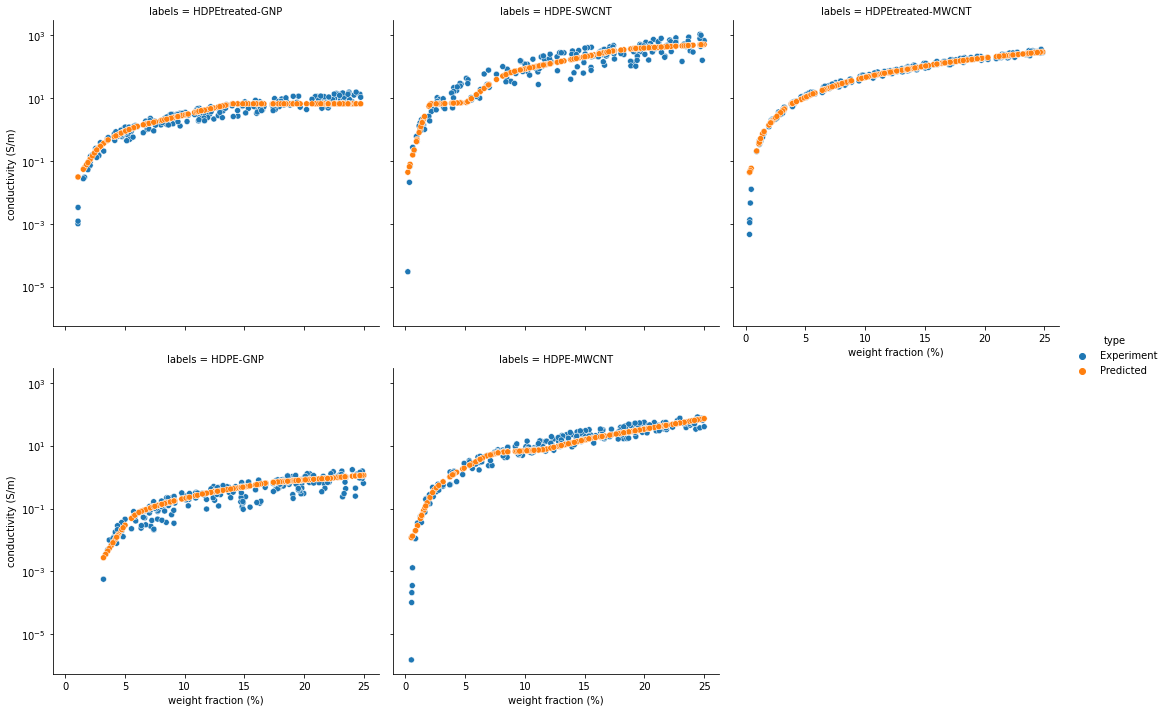

In [11]:
# Calculate predictions
PredValSet = model.predict(X_scaled_testing)
PredValSet2 = Y_scaler.inverse_transform(PredValSet)

compdata = testing_data.copy()
compdata = mapNumToString (compdata)

compdata['labels']    = compdata['polymer_1'] + "-" + compdata['filler_1']
compdata['type'] = 'Experiment'
compdata2 = compdata.copy()
compdata2['type'] = 'Predicted'
compdata2['conductivity'] = PredValSet2

compdata = compdata.append(compdata2, ignore_index = True)

g = sns.relplot(data=compdata ,x="wt_l1", y ="conductivity", hue="type", col="labels", kind="scatter", col_wrap =3  );
g.set_xlabels("weight fraction (%)");
g.set_ylabels("conductivity (S/m)");
g.set(yscale="log");

## Saving data

In [13]:
model.save('saved/predictor-conductivity-model')
# To be convenient, the SCALERs will be saved 
from pickle import dump
# save the model
#dump(model, open('model.pkl', 'wb'))
# save the scaler
dump(X_scaler, open('saved/X_scaler.pkl', 'wb'))
dump(Y_scaler, open('saved/Y_scaler.pkl', 'wb'))

INFO:tensorflow:Assets written to: saved/predictor-conductivity-model\assets


# Conclusion

## Results are acceptable
The difference between prediction and experiment is within one order of magnitude, which is acceptable.

## Issues
There are a strange behaviour at range around 5%. 

However, our data (conductivity) of different fillers is highly divergent. The carbon nanotube has much higher in intrisic conductivity, leading CNT-based composite has much higher electrical conductivity than the GNP one. Also, the values of threshold in cases of CNT-based composite are much smaller than GNP one. That why there is inconsistent area at 5%.

The X-axis might need scaling with different Scaler which prefers logarithmic scales.